<a href="https://colab.research.google.com/github/aaperei/data-science/blob/main/benchmark_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projecto Final - 2021/2S Redes Neurais - UNIFESP
Alison Augusto M Perera
---


O presente trabalho tem o objetivo de comparar diversos modelos de redes neurais do tipo `CNN` - *Convolutional Neural Networks* - na tarefa de classificação de imagens. Utilizou-se da técnica de *transfer learning* a fim de se reutilizar modelos pré-treinados, fazendo apenas pequenos ajustes na camada de saída do modelo para a adaptação para o conjunto de dados em questão.

# Processo utilizado
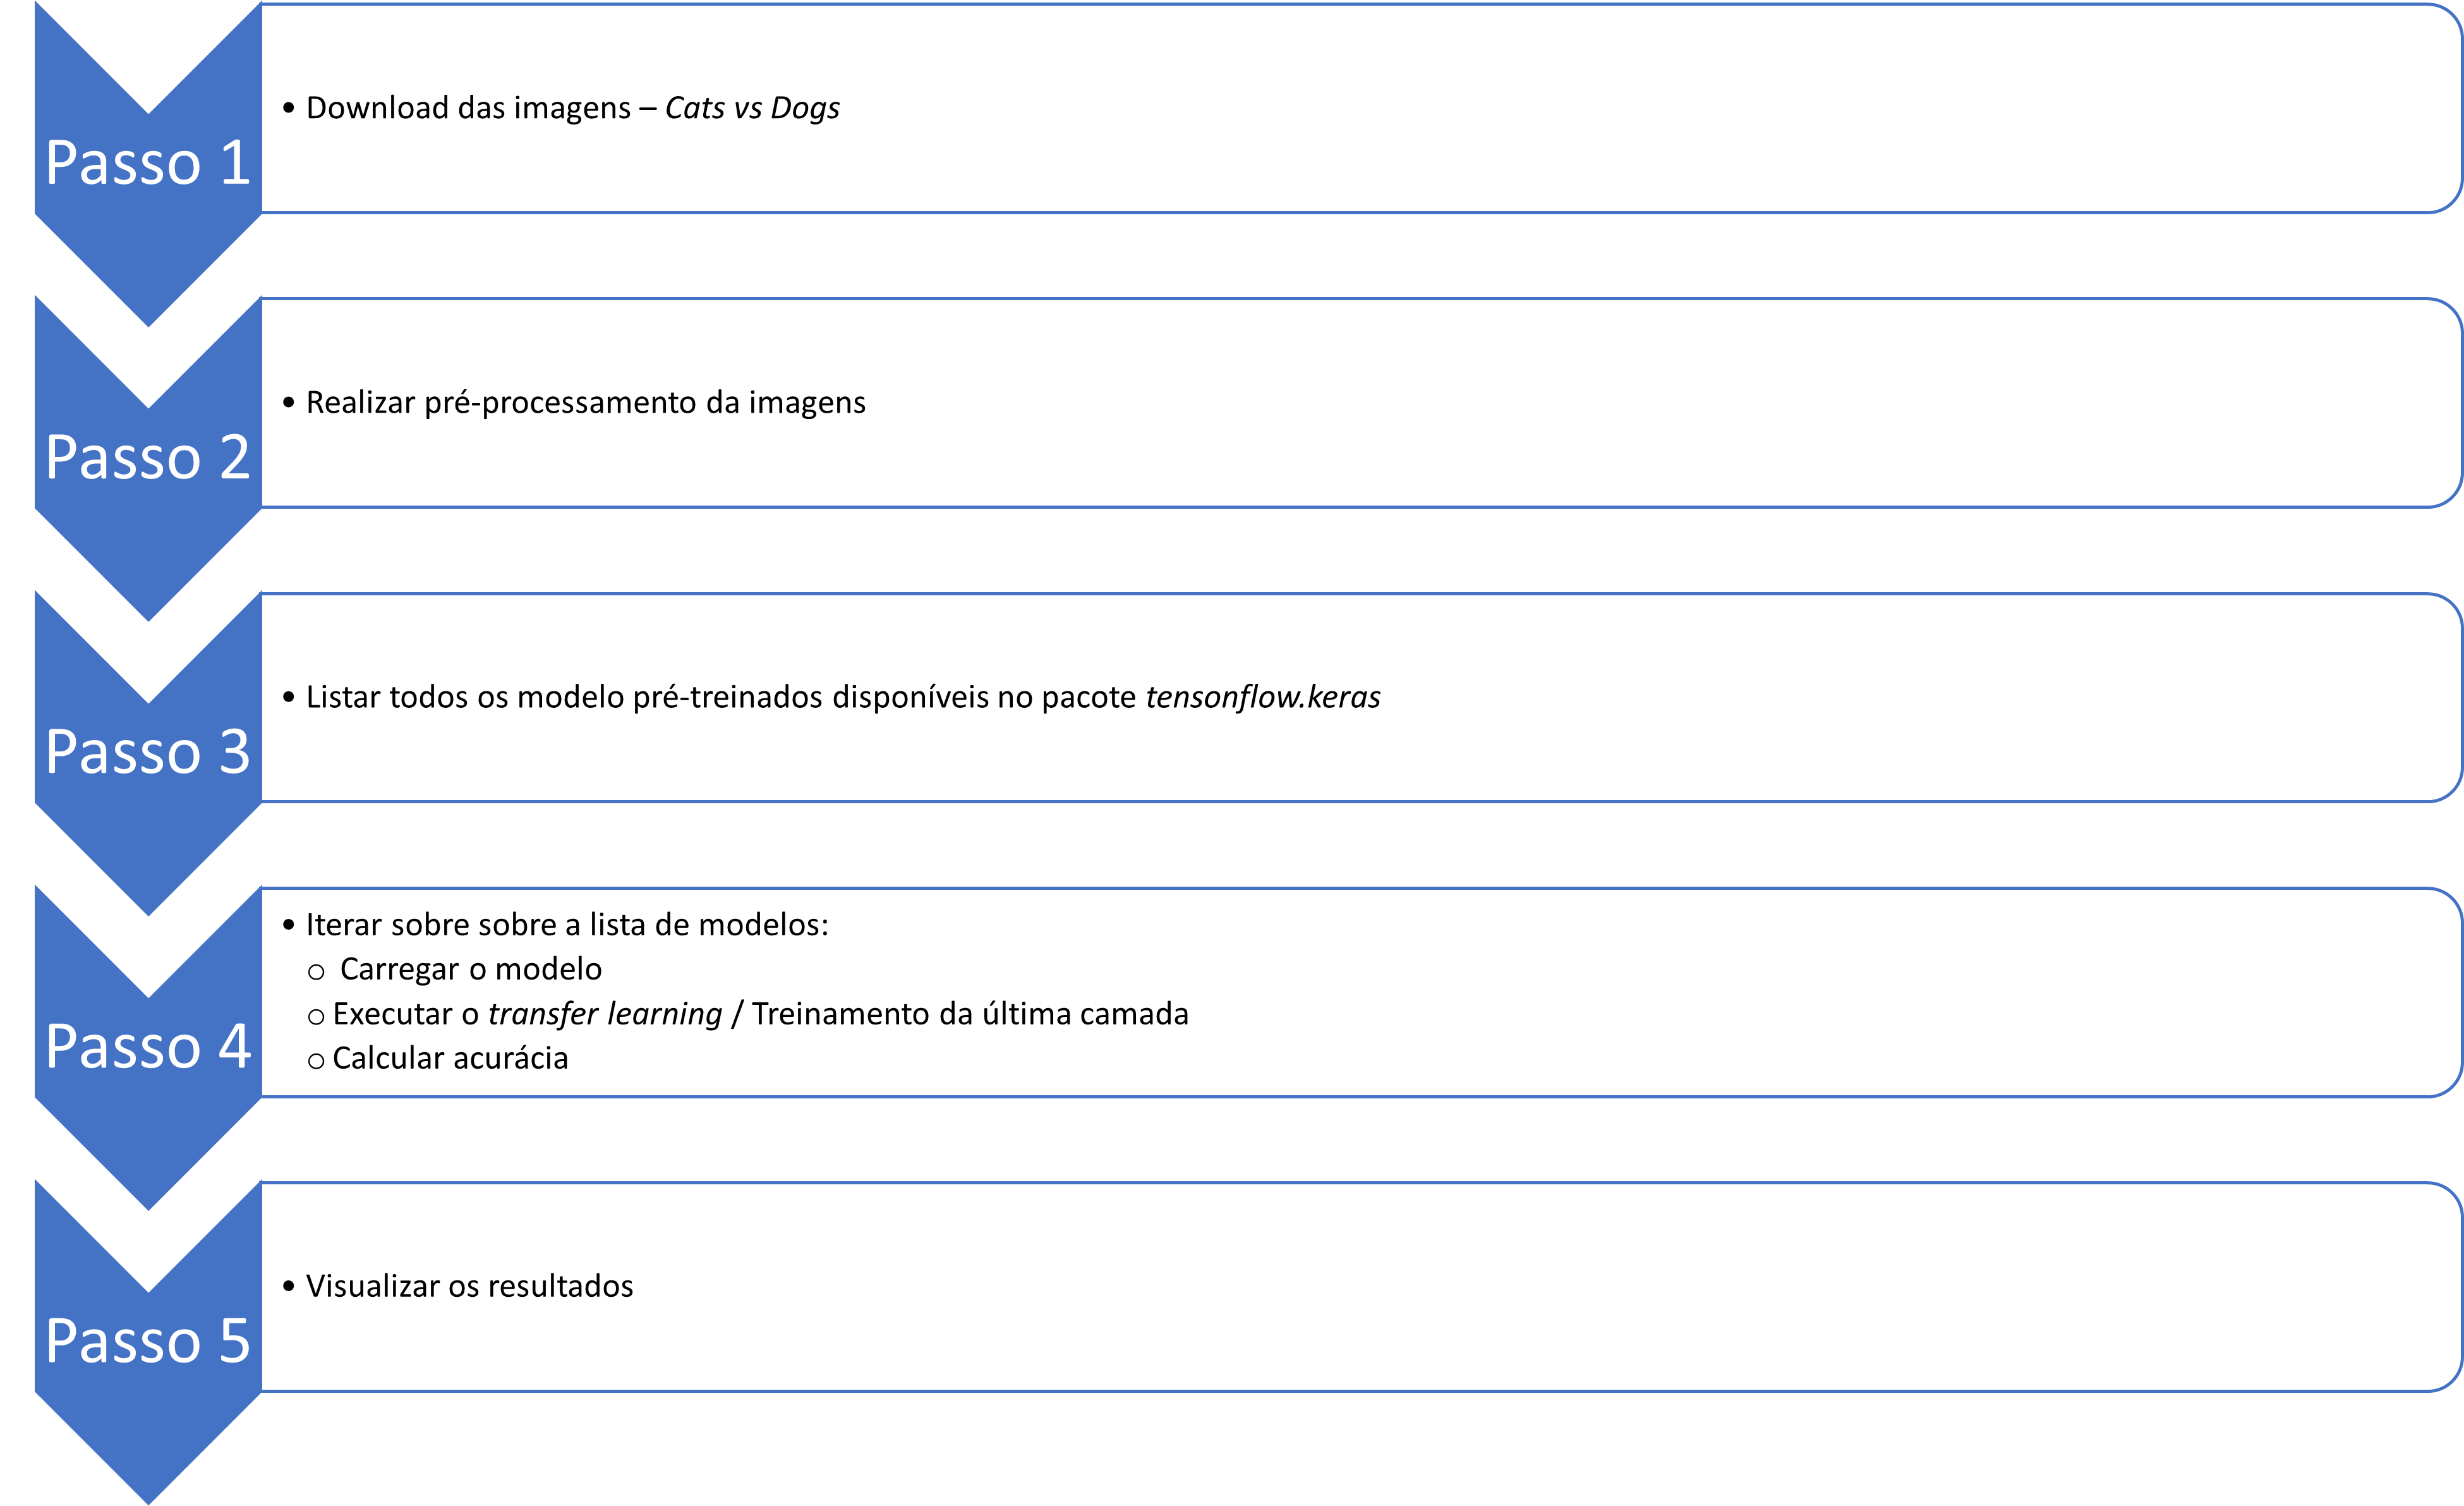



In [1]:
# Show GPU properties

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 14 17:26:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Show RAM properties
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm
import time

# Set batch size for training and validation
batch_size = 32

In [4]:
# Download the training and validation data
(train, validation), metadata = tfds.load('cats_vs_dogs', split=['train[:70%]', 'train[70%:]'], 
                                          with_info=True, as_supervised=True)

# Number of training examples and labels
num_train = len(list(train))
num_validation = len(list(validation))
num_classes = len(metadata.features['label'].names)
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteB8DA28/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Num train images: 16283         
Num validation images: 6979         
Num classes: 2         
Num iterations per epoch: 508


In [5]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    train_processed = train_processed.batch(batch_size).repeat()

    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    validation_processed = validation_processed.batch(batch_size)

    return train_processed, validation_processed

# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train, validation, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331 = preprocess_data(train, validation, batch_size, img_size=[331,331])

In [6]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_dictionary

{'DenseNet121': <function keras.applications.densenet.DenseNet121>,
 'DenseNet169': <function keras.applications.densenet.DenseNet169>,
 'DenseNet201': <function keras.applications.densenet.DenseNet201>,
 'EfficientNetB0': <function keras.applications.efficientnet.EfficientNetB0>,
 'EfficientNetB1': <function keras.applications.efficientnet.EfficientNetB1>,
 'EfficientNetB2': <function keras.applications.efficientnet.EfficientNetB2>,
 'EfficientNetB3': <function keras.applications.efficientnet.EfficientNetB3>,
 'EfficientNetB4': <function keras.applications.efficientnet.EfficientNetB4>,
 'EfficientNetB5': <function keras.applications.efficientnet.EfficientNetB5>,
 'EfficientNetB6': <function keras.applications.efficientnet.EfficientNetB6>,
 'EfficientNetB7': <function keras.applications.efficientnet.EfficientNetB7>,
 'InceptionResNetV2': <function keras.applications.inception_resnet_v2.InceptionResNetV2>,
 'InceptionV3': <function keras.applications.inception_v3.InceptionV3>,
 'MobileN

In [7]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': [], 'train_time': []}
for model_name, model in tqdm(model_dictionary.items()):
    start_time = time.time()
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed, 
                            steps_per_epoch=num_iterations)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['train_time'].append(time.time()-start_time)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

  0%|          | 0/28 [00:00<?, ?it/s]

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 53s 80ms/step - loss: 0.0683 - accuracy: 0.9732 - val_loss: 0.0402 - val_accuracy: 0.9841
Epoch 2/3
508/508 [==============================] - 39s 77ms/step - loss: 0.0374 - accuracy: 0.9862 - val_loss: 0.0407 - val_accuracy: 0.9848
Epoch 3/3
508/508 [==============================] - 39s 77ms/step - loss: 0.0336 - accuracy: 0.9879 - val_loss: 0.0348 - val_accuracy: 0.9868


  4%|▎         | 1/28 [02:15<1:00:52, 135.27s/it]

51888128/51877672 [==============================] - 2s 0us/step
Epoch 1/3
508/508 [==============================] - 59s 101ms/step - loss: 0.0563 - accuracy: 0.9799 - val_loss: 0.0290 - val_accuracy: 0.9905
Epoch 2/3
508/508 [==============================] - 49s 97ms/step - loss: 0.0305 - accuracy: 0.9895 - val_loss: 0.0281 - val_accuracy: 0.9910
Epoch 3/3
508/508 [==============================] - 49s 97ms/step - loss: 0.0272 - accuracy: 0.9906 - val_loss: 0.0289 - val_accuracy: 0.9900


  7%|▋         | 2/28 [04:59<1:05:56, 152.19s/it]

74850304/74836368 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 74s 129ms/step - loss: 0.0506 - accuracy: 0.9816 - val_loss: 0.0267 - val_accuracy: 0.9903
Epoch 2/3
508/508 [==============================] - 62s 122ms/step - loss: 0.0302 - accuracy: 0.9893 - val_loss: 0.0260 - val_accuracy: 0.9913
Epoch 3/3
508/508 [==============================] - 65s 127ms/step - loss: 0.0263 - accuracy: 0.9914 - val_loss: 0.0266 - val_accuracy: 0.9908


 11%|█         | 3/28 [08:26<1:13:55, 177.44s/it]

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 34s 57ms/step - loss: 0.6974 - accuracy: 0.5024 - val_loss: 0.6960 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 28s 55ms/step - loss: 0.6978 - accuracy: 0.4977 - val_loss: 0.6974 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 28s 55ms/step - loss: 0.6974 - accuracy: 0.5050 - val_loss: 0.6928 - val_accuracy: 0.5044


 14%|█▍        | 4/28 [09:59<57:34, 143.94s/it]  

27033600/27018416 [==============================] - 1s 0us/step
Epoch 1/3
508/508 [==============================] - 47s 78ms/step - loss: 0.6995 - accuracy: 0.5017 - val_loss: 0.7006 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 38s 75ms/step - loss: 0.6997 - accuracy: 0.4954 - val_loss: 0.7031 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 38s 75ms/step - loss: 0.6993 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5038


 18%|█▊        | 5/28 [12:07<52:59, 138.23s/it]

31801344/31790344 [==============================] - 1s 0us/step
Epoch 1/3
508/508 [==============================] - 49s 82ms/step - loss: 0.7021 - accuracy: 0.5009 - val_loss: 0.7030 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 40s 78ms/step - loss: 0.7017 - accuracy: 0.5002 - val_loss: 0.7049 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 40s 78ms/step - loss: 0.7016 - accuracy: 0.4999 - val_loss: 0.6928 - val_accuracy: 0.5187


 21%|██▏       | 6/28 [14:20<49:59, 136.34s/it]

43950080/43941136 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 60s 102ms/step - loss: 0.7067 - accuracy: 0.5076 - val_loss: 0.6926 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 50s 99ms/step - loss: 0.7042 - accuracy: 0.5115 - val_loss: 0.7105 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 50s 99ms/step - loss: 0.7026 - accuracy: 0.5165 - val_loss: 0.6848 - val_accuracy: 0.5605


 25%|██▌       | 7/28 [17:04<50:57, 145.62s/it]

71696384/71686520 [==============================] - 1s 0us/step
Epoch 1/3
508/508 [==============================] - 78s 134ms/step - loss: 0.7101 - accuracy: 0.5014 - val_loss: 0.7010 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 66s 130ms/step - loss: 0.7099 - accuracy: 0.5014 - val_loss: 0.7161 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 66s 130ms/step - loss: 0.7099 - accuracy: 0.5012 - val_loss: 0.6949 - val_accuracy: 0.4962


 29%|██▊       | 8/28 [20:41<56:03, 168.16s/it]

115277824/115263384 [==============================] - 4s 0us/step
Epoch 1/3
508/508 [==============================] - 120s 213ms/step - loss: 0.7136 - accuracy: 0.5023 - val_loss: 0.7013 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 90s 178ms/step - loss: 0.7131 - accuracy: 0.5014 - val_loss: 0.7383 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 90s 177ms/step - loss: 0.7125 - accuracy: 0.5058 - val_loss: 0.6909 - val_accuracy: 0.5237


 32%|███▏      | 9/28 [25:52<1:07:23, 212.81s/it]

165249024/165234480 [==============================] - 6s 0us/step
Epoch 1/3
508/508 [==============================] - 141s 251ms/step - loss: 0.7176 - accuracy: 0.5089 - val_loss: 0.6988 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 118s 231ms/step - loss: 0.7162 - accuracy: 0.5098 - val_loss: 0.7472 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 118s 231ms/step - loss: 0.7157 - accuracy: 0.5102 - val_loss: 0.6883 - val_accuracy: 0.5870


 36%|███▌      | 10/28 [32:21<1:20:09, 267.17s/it]

258088960/258076736 [==============================] - 9s 0us/step
Epoch 1/3
508/508 [==============================] - 180s 321ms/step - loss: 0.7232 - accuracy: 0.4997 - val_loss: 0.7015 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 160s 314ms/step - loss: 0.7227 - accuracy: 0.4982 - val_loss: 0.7481 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 195s 384ms/step - loss: 0.7222 - accuracy: 0.4971 - val_loss: 0.6972 - val_accuracy: 0.4962


 39%|███▉      | 11/28 [41:33<1:40:27, 354.57s/it]

219070464/219055592 [==============================] - 1s 0us/step
Epoch 1/3
508/508 [==============================] - 89s 155ms/step - loss: 0.0502 - accuracy: 0.9840 - val_loss: 0.0330 - val_accuracy: 0.9920
Epoch 2/3
508/508 [==============================] - 76s 149ms/step - loss: 0.0306 - accuracy: 0.9913 - val_loss: 0.0318 - val_accuracy: 0.9933
Epoch 3/3
508/508 [==============================] - 76s 150ms/step - loss: 0.0275 - accuracy: 0.9921 - val_loss: 0.0308 - val_accuracy: 0.9930


 43%|████▎     | 12/28 [45:41<1:25:50, 321.92s/it]

87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 37s 65ms/step - loss: 0.0571 - accuracy: 0.9814 - val_loss: 0.0348 - val_accuracy: 0.9895
Epoch 2/3
508/508 [==============================] - 32s 63ms/step - loss: 0.0377 - accuracy: 0.9874 - val_loss: 0.0379 - val_accuracy: 0.9894
Epoch 3/3
508/508 [==============================] - 32s 63ms/step - loss: 0.0320 - accuracy: 0.9902 - val_loss: 0.0391 - val_accuracy: 0.9891


 46%|████▋     | 13/28 [47:24<1:03:56, 255.75s/it]

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 19s 35ms/step - loss: 0.0706 - accuracy: 0.9725 - val_loss: 0.0374 - val_accuracy: 0.9864
Epoch 2/3
508/508 [==============================] - 17s 34ms/step - loss: 0.0376 - accuracy: 0.9870 - val_loss: 0.0341 - val_accuracy: 0.9887
Epoch 3/3
508/508 [==============================] - 17s 34ms/step - loss: 0.0323 - accuracy: 0.9890 - val_loss: 0.0343 - val_accuracy: 0.9880


 50%|█████     | 14/28 [48:18<45:28, 194.88s/it]  

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 22s 40ms/step - loss: 0.0661 - accuracy: 0.9763 - val_loss: 0.0448 - val_accuracy: 0.9842
Epoch 2/3
508/508 [==============================] - 19s 38ms/step - loss: 0.0430 - accuracy: 0.9849 - val_loss: 0.0420 - val_accuracy: 0.9862
Epoch 3/3
508/508 [==============================] - 19s 38ms/step - loss: 0.0379 - accuracy: 0.9873 - val_loss: 0.0477 - val_accuracy: 0.9841


 54%|█████▎    | 15/28 [49:21<33:34, 154.94s/it]

17620992/17605208 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 25s 40ms/step - loss: 0.6948 - accuracy: 0.5482 - val_loss: 0.6706 - val_accuracy: 0.5789
Epoch 2/3
508/508 [==============================] - 19s 37ms/step - loss: 0.6801 - accuracy: 0.5799 - val_loss: 0.7206 - val_accuracy: 0.5082
Epoch 3/3
508/508 [==============================] - 19s 38ms/step - loss: 0.6740 - accuracy: 0.5886 - val_loss: 0.6554 - val_accuracy: 0.6104


 57%|█████▋    | 16/28 [50:26<25:37, 128.08s/it]

6709248/6698480 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 21s 36ms/step - loss: 0.6800 - accuracy: 0.5635 - val_loss: 0.6592 - val_accuracy: 0.6124
Epoch 2/3
508/508 [==============================] - 18s 35ms/step - loss: 0.6651 - accuracy: 0.5958 - val_loss: 0.6877 - val_accuracy: 0.5194
Epoch 3/3
508/508 [==============================] - 18s 35ms/step - loss: 0.6598 - accuracy: 0.6046 - val_loss: 0.6427 - val_accuracy: 0.6293


 61%|██████    | 17/28 [51:25<19:39, 107.24s/it]

343621632/343610240 [==============================] - 10s 0us/step
Epoch 1/3
508/508 [==============================] - 439s 834ms/step - loss: 0.0224 - accuracy: 0.9947 - val_loss: 0.0170 - val_accuracy: 0.9950
Epoch 2/3
508/508 [==============================] - 394s 775ms/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.0186 - val_accuracy: 0.9947
Epoch 3/3
508/508 [==============================] - 419s 825ms/step - loss: 0.0105 - accuracy: 0.9976 - val_loss: 0.0196 - val_accuracy: 0.9946


 64%|██████▍   | 18/28 [1:12:36<1:16:08, 456.83s/it]

20004864/19993432 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 51s 79ms/step - loss: 0.0498 - accuracy: 0.9841 - val_loss: 0.0340 - val_accuracy: 0.9894
Epoch 2/3
508/508 [==============================] - 37s 73ms/step - loss: 0.0315 - accuracy: 0.9889 - val_loss: 0.0355 - val_accuracy: 0.9893
Epoch 3/3
508/508 [==============================] - 37s 73ms/step - loss: 0.0284 - accuracy: 0.9903 - val_loss: 0.0354 - val_accuracy: 0.9893


 68%|██████▊   | 19/28 [1:14:48<53:54, 359.34s/it]  

171458560/171446536 [==============================] - 1s 0us/step
Epoch 1/3
508/508 [==============================] - 72s 132ms/step - loss: 0.6634 - accuracy: 0.6008 - val_loss: 0.6527 - val_accuracy: 0.6073
Epoch 2/3
508/508 [==============================] - 63s 125ms/step - loss: 0.6367 - accuracy: 0.6398 - val_loss: 0.6441 - val_accuracy: 0.6123
Epoch 3/3
508/508 [==============================] - 63s 125ms/step - loss: 0.6228 - accuracy: 0.6568 - val_loss: 0.6107 - val_accuracy: 0.6762


 71%|███████▏  | 20/28 [1:18:11<41:38, 312.25s/it]

171327488/171317808 [==============================] - 1s 0us/step
Epoch 1/3
508/508 [==============================] - 71s 126ms/step - loss: 0.0512 - accuracy: 0.9819 - val_loss: 0.0399 - val_accuracy: 0.9884
Epoch 2/3
508/508 [==============================] - 65s 128ms/step - loss: 0.0332 - accuracy: 0.9901 - val_loss: 0.0451 - val_accuracy: 0.9878
Epoch 3/3
508/508 [==============================] - 63s 124ms/step - loss: 0.0285 - accuracy: 0.9914 - val_loss: 0.0447 - val_accuracy: 0.9884


 75%|███████▌  | 21/28 [1:21:34<32:37, 279.62s/it]

234708992/234698864 [==============================] - 1s 0us/step
Epoch 1/3
508/508 [==============================] - 101s 183ms/step - loss: 0.6737 - accuracy: 0.5777 - val_loss: 0.6550 - val_accuracy: 0.6193
Epoch 2/3
508/508 [==============================] - 91s 179ms/step - loss: 0.6481 - accuracy: 0.6253 - val_loss: 0.6529 - val_accuracy: 0.6031
Epoch 3/3
508/508 [==============================] - 91s 179ms/step - loss: 0.6366 - accuracy: 0.6419 - val_loss: 0.6212 - val_accuracy: 0.6726


 79%|███████▊  | 22/28 [1:26:23<28:13, 282.31s/it]

234561536/234545216 [==============================] - 8s 0us/step
Epoch 1/3
508/508 [==============================] - 101s 184ms/step - loss: 0.0519 - accuracy: 0.9814 - val_loss: 0.0414 - val_accuracy: 0.9864
Epoch 2/3
508/508 [==============================] - 91s 180ms/step - loss: 0.0326 - accuracy: 0.9899 - val_loss: 0.0411 - val_accuracy: 0.9864
Epoch 3/3
508/508 [==============================] - 91s 180ms/step - loss: 0.0277 - accuracy: 0.9922 - val_loss: 0.0407 - val_accuracy: 0.9878


 82%|████████▏ | 23/28 [1:32:06<25:03, 300.61s/it]

94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 42s 78ms/step - loss: 0.6683 - accuracy: 0.5897 - val_loss: 0.6508 - val_accuracy: 0.6167
Epoch 2/3
508/508 [==============================] - 39s 76ms/step - loss: 0.6508 - accuracy: 0.6214 - val_loss: 0.6572 - val_accuracy: 0.6005
Epoch 3/3
508/508 [==============================] - 39s 76ms/step - loss: 0.6426 - accuracy: 0.6309 - val_loss: 0.6274 - val_accuracy: 0.6535


 86%|████████▌ | 24/28 [1:34:08<16:27, 246.93s/it]

94683136/94668760 [==============================] - 1s 0us/step
Epoch 1/3
508/508 [==============================] - 40s 74ms/step - loss: 0.0562 - accuracy: 0.9796 - val_loss: 0.0442 - val_accuracy: 0.9860
Epoch 2/3
508/508 [==============================] - 37s 72ms/step - loss: 0.0364 - accuracy: 0.9884 - val_loss: 0.0463 - val_accuracy: 0.9868
Epoch 3/3
508/508 [==============================] - 47s 92ms/step - loss: 0.0307 - accuracy: 0.9902 - val_loss: 0.0488 - val_accuracy: 0.9854


 89%|████████▉ | 25/28 [1:36:14<10:32, 210.73s/it]

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 48s 88ms/step - loss: 0.4401 - accuracy: 0.8325 - val_loss: 0.3267 - val_accuracy: 0.8845
Epoch 2/3
508/508 [==============================] - 46s 87ms/step - loss: 0.2895 - accuracy: 0.8935 - val_loss: 0.2638 - val_accuracy: 0.9021
Epoch 3/3
508/508 [==============================] - 44s 87ms/step - loss: 0.2500 - accuracy: 0.9057 - val_loss: 0.2345 - val_accuracy: 0.9104


 93%|█████████▎| 26/28 [1:38:33<06:18, 189.28s/it]

80150528/80134624 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 53s 104ms/step - loss: 0.4809 - accuracy: 0.7992 - val_loss: 0.3686 - val_accuracy: 0.8600
Epoch 2/3
508/508 [==============================] - 52s 103ms/step - loss: 0.3320 - accuracy: 0.8741 - val_loss: 0.3034 - val_accuracy: 0.8842
Epoch 3/3
508/508 [==============================] - 52s 103ms/step - loss: 0.2896 - accuracy: 0.8883 - val_loss: 0.2732 - val_accuracy: 0.8950


 96%|█████████▋| 27/28 [1:41:12<03:00, 180.21s/it]

83697664/83683744 [==============================] - 2s 0us/step
Epoch 1/3
508/508 [==============================] - 58s 109ms/step - loss: 0.0499 - accuracy: 0.9836 - val_loss: 0.0363 - val_accuracy: 0.9868
Epoch 2/3
508/508 [==============================] - 53s 104ms/step - loss: 0.0315 - accuracy: 0.9893 - val_loss: 0.0316 - val_accuracy: 0.9881
Epoch 3/3
508/508 [==============================] - 53s 104ms/step - loss: 0.0275 - accuracy: 0.9910 - val_loss: 0.0326 - val_accuracy: 0.9880


100%|██████████| 28/28 [1:44:00<00:00, 222.88s/it]


In [8]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('benchmark_df.csv', index=False) # write results to csv file
benchmark_df

,model_name,num_model_params,validation_accuracy,train_time
16,MobileNetV3Small,1529968,0.629317,58.746547
14,MobileNetV2,2257984,0.984095,62.387651
13,MobileNet,3228864,0.987964,54.216135
3,EfficientNetB0,4049571,0.504370,92.572814
15,MobileNetV3Large,4226432,0.610403,65.701440
18,NASNetMobile,4269716,0.989253,132.241885
4,EfficientNetB1,6575239,0.503797,128.118685
0,DenseNet121,7037504,0.986818,135.261399
5,EfficientNetB2,7768569,0.518699,132.646766
6,EfficientNetB3,10783535,0.560539,164.709321


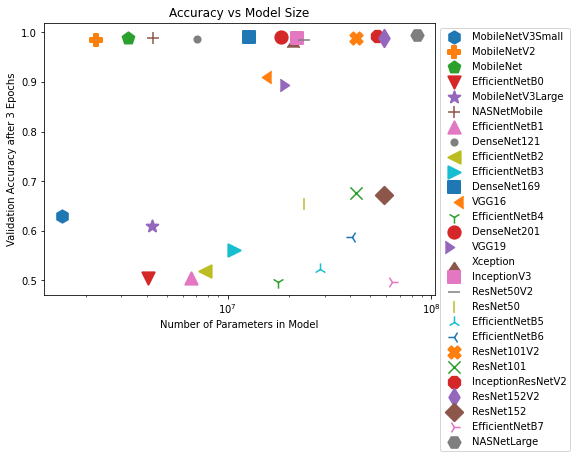

In [9]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot

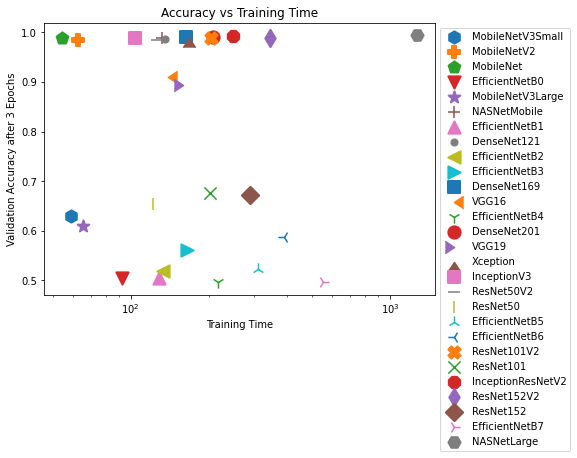

In [10]:
# Loop over each row and plot the train_time vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.train_time, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Training Time')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Training Time')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot